## Introduction
This notebook evaluates models in a dataset to detect backdoors using the DISTIL library.



## Setup and Imports


In [ ]:
!pip install git+https://github.com/openai/glide-text2im

In [ ]:
!git clone https://github.com/ex3ploiter/DISTIL.git

In [1]:
# Import required libraries
import sys
import os
import yaml
import argparse
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
from tqdm.auto import tqdm
import gdown
import zipfile
from pathlib import Path


# Add the repository root to the Python path
sys.path.append('../../../')

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from types import SimpleNamespace
import torchvision
from sklearn.metrics import roc_auc_score

from DISTIL.DISTIL.data_loader import model_loader
from DISTIL.DISTIL.detection import backdoor_detector


## Configuration


In [ ]:
# Configuration for backdoor detection evaluation

# Dataset settings
# BASE_PATH = "/home/public/data/masoud/Projects/Backdoor/image-classification-jun2020-test"
BASE_PATH = "./image-classification-jun2020-test"
MODELS_DIR= os.path.join(BASE_PATH,'models')
METADATA_PATH= os.path.join(BASE_PATH,'METADATA.csv')  # Optional, set to None if not used

# Output settings
OUTPUT_DIR= "./evaluation_results"
SAVE_TRIGGERS= True

# Detection parameters
GUIDANCE_SCALE= 100.0
NUM_ITERATIONS= 2
TIMESTEP= 50
ADD_NOISE= True  # Whether to add noise during image transformation
GRAD_SCALE_FACTOR= 0.142857  # Equivalent to 1/7

# Search strategy
# Options: 
#   - "greedy": Use greedy_class_farthest to identify potential source-target pairs
#   - "exhaustive": Try all possible source-target label pairs 
SEARCH_STRATEGY= "greedy"

# Hardware settings
NO_CUDA= False  # Set to true to disable CUDA even if available 

## Setup

In [ ]:
# ## Setting up Device

# Set device (CPU or GPU)
if NO_CUDA or not torch.cuda.is_available():
    device = torch.device("cpu")
    print("Using CPU for evaluation")
else:
    device = torch.device("cuda")
    print(f"Using GPU for evaluation: {torch.cuda.get_device_name(0)}")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)


torch.manual_seed(0)

Using GPU for evaluation: NVIDIA RTX A6000


## Download the models

In [4]:
# !gdown --folder 1YoxK4kIe6vZfURPTjaxWLLcA8EAr8uCs

In [5]:
# import os
# import tarfile

# def extract_tar_gz_files_in_folder(folder_path):
#     # Loop through all files in the specified folder
#     for item in os.listdir(folder_path):
#         # Check if the item is a tar.gz file
#         if item.endswith('.tar.gz'):
#             tar_file_path = os.path.join(folder_path, item)
#             # Create a directory to extract the contents
#             extract_folder = os.path.join(folder_path, item[:-7])  # Remove .tar.gz from the name
#             os.makedirs(extract_folder, exist_ok=True)  # Create the directory if it doesn't exist

#             # if os.path.exists(extract_folder):
#             #     print(f'{extract_folder} already exists')
#             #     continue

#             # Extract the tar.gz file
#             with tarfile.open(tar_file_path, 'r:gz') as tar_ref:
#                 tar_ref.extractall(extract_folder)
#                 print(f'Extracted {item} to {extract_folder}')


# extract_tar_gz_files_in_folder(MODELS_DIR)


## Model Evaluation Function

In [6]:
def evaluate_models(dataset, is_backdoored):
    """
    Evaluate a set of models and return their backdoor detection scores.
    
    Args:
        dataset: Dataset of models to evaluate
        is_backdoored: Whether the models are known to be backdoored
        
    Returns:
        results: List of dictionaries with model information and scores
    """
    results = []
    
    # Create a directory for trigger images if saving
    triggers_dir = os.path.join(OUTPUT_DIR, "triggers")
    if SAVE_TRIGGERS:
        os.makedirs(triggers_dir, exist_ok=True)
    
    model_type='Clean' if is_backdoored==False else 'Backdoor'
    # Evaluate each model
    for i in tqdm(range(len(dataset)),desc=f"Processing {model_type} models", unit="items"):
        if i==0:
            continue
        model_data = dataset[i]
        model_id = model_data["model_id"]
        parent_id = model_data["parent_id"]
        
        
        
        # Get start time
        start_time = time.time()
        
        # Detect backdoor and get score
        try:
            max_score, trigger = backdoor_detector.detect_backdoor(
                model_data,
                metadata_path=METADATA_PATH if is_backdoored else None,
                guidance_scale=GUIDANCE_SCALE,
                num_iterations=NUM_ITERATIONS,
                timestep=TIMESTEP,
                search_strategy=SEARCH_STRATEGY,
                add_noise=ADD_NOISE,
                grad_scale_factor=GRAD_SCALE_FACTOR
            )
            
            # Save trigger image if requested
            if SAVE_TRIGGERS and trigger is not None:
                trigger_path = os.path.join(triggers_dir, f"{parent_id}_{model_id}.png")
                torchvision.utils.save_image(trigger.cpu(), trigger_path)
            
            # Calculate time taken
            time_taken = time.time() - start_time
            # Store results
            results.append({
                "model_id": model_id,
                "parent_id": parent_id,
                "full_path": model_data["model_path"],
                "is_backdoored": 1 if is_backdoored else 0,
                "score": max_score,
                "time_taken": time_taken,
                "search_strategy": SEARCH_STRATEGY
            })
            
            # print(f"Score: {max_score:.4f}, Time: {time_taken:.2f}s")
            
        except Exception as e:
            # print(f"Error evaluating model {parent_id}/{model_id}: {e}")
            results.append({
                "model_id": model_id,
                "parent_id": parent_id,
                "full_path": model_data["model_path"],
                "is_backdoored": 1 if is_backdoored else 0,
                "score": -1,  # Error indicator
                "time_taken": -1,
                "error": str(e),
                "search_strategy": SEARCH_STRATEGY
            })
    
    return results

## Evaluate the models

In [7]:


# Load clean and backdoored models
clean_dataset, backdoor_dataset = model_loader.load_models(MODELS_DIR,limit_model=None)

print(f"Found {len(clean_dataset)} clean models")
print(f"Found {len(backdoor_dataset)} backdoored models")

# ## Evaluating Models

all_results = []

# Evaluate clean models
if len(clean_dataset) > 0:
    print("\nEvaluating clean models...")
    clean_results = evaluate_models(clean_dataset, is_backdoored=False)
    all_results.extend(clean_results)

# Evaluate backdoored models
if len(backdoor_dataset) > 0:
    print("\nEvaluating backdoored models...")
    backdoor_results = evaluate_models(backdoor_dataset, is_backdoored=True)
    all_results.extend(backdoor_results)

# ## Analyze and Visualize Results

# Create DataFrame from results
results_df = pd.DataFrame(all_results)

# Save results to CSV
csv_path = os.path.join(OUTPUT_DIR, "detection_scores.csv")
results_df.to_csv(csv_path, index=False)
print(f"\nResults saved to {csv_path}")

# Calculate and display statistics
if len(results_df) > 0:
    print("\nEvaluation Statistics:")
    
    # Filter out error cases
    valid_results = results_df[results_df["score"] >= 0]
    
    if len(valid_results) > 0:
        clean_scores = valid_results[valid_results["is_backdoored"] == 0]["score"].values
        backdoor_scores = valid_results[valid_results["is_backdoored"] == 1]["score"].values
        
        # Calculate separation statistics
        if len(clean_scores) > 0 and len(backdoor_scores) > 0:
            # Find threshold that maximizes accuracy
            all_scores = np.concatenate([clean_scores, backdoor_scores])
            all_labels = np.concatenate([np.zeros_like(clean_scores), np.ones_like(backdoor_scores)])
            
            # Calculate ROC AUC
            auc_score = roc_auc_score(all_labels, all_scores)
            print(f"\nROC AUC Score: {auc_score:.4f}")            

print("\nEvaluation complete!")

Found 50 clean models
Found 50 backdoored models

Evaluating clean models...


Processing Clean models:   0%|          | 0/50 [00:00<?, ?items/s]


Evaluating backdoored models...


Processing Backdoor models:   0%|          | 0/50 [00:00<?, ?items/s]


Results saved to ./evaluation_results/detection_scores.csv

Evaluation Statistics:

ROC AUC Score: 0.8199

Evaluation complete!


## Plotting the Triggers
In the following section, the triggers generated for both clean and backdoored models will be presented. We will only demonstrate the trigger that caused the highest shift in the score.

In [37]:
backdoored_dataframe = results_df[results_df['is_backdoored'] == 1]
clean_dataframe = results_df[results_df['is_backdoored'] == 0]


In [41]:
def load_images_from_dataframe(df, output_dir):
    """Helper function to load images from a dataframe."""
    images = []
    base_path = Path(output_dir) / 'triggers'
    
    for parent_id, model_id in zip(df['parent_id'], df['model_id']):
        img_path = base_path / f'{parent_id}_{model_id}.png'
        if img_path.exists():
            img = torchvision.io.read_image(str(img_path)).float() / 255.0
            images.append(img)
    return images

# Load images
backdoor_imgs = load_images_from_dataframe(backdoored_dataframe, OUTPUT_DIR)
clean_imgs = load_images_from_dataframe(clean_dataframe, OUTPUT_DIR)

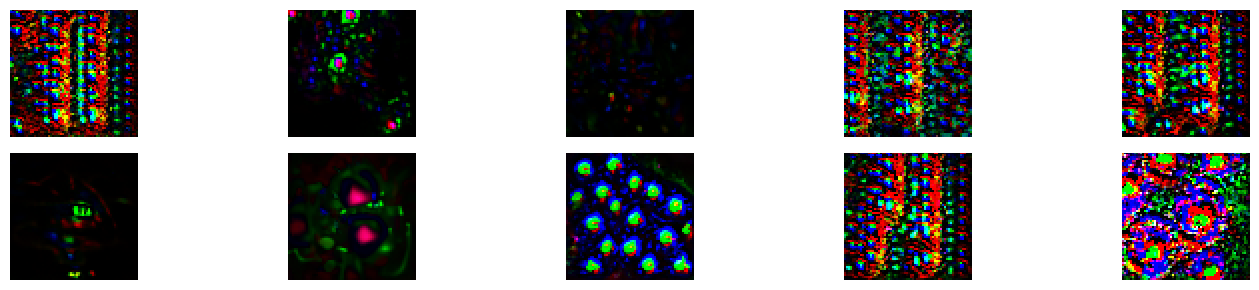

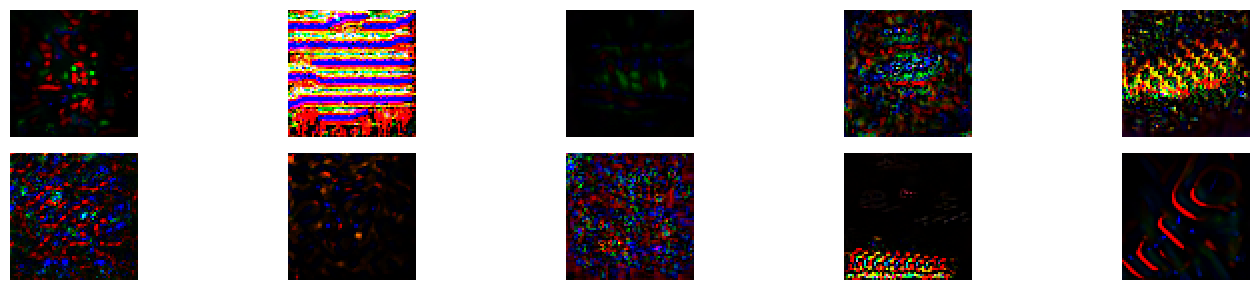

In [42]:
import matplotlib.pyplot as plt

def show_images(images, titles=None, cols=5, figsize=(15, 5)):
    """Display a grid of images."""
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)
    
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        plt.axis('off')
        if titles and i < len(titles):
            plt.title(titles[i])
    
    plt.tight_layout()
    plt.show()

# Display first 10 backdoored images
show_images(backdoor_imgs[:10], cols=5, figsize=(15, 3))

# Display first 10 clean images
show_images(clean_imgs[:10], cols=5, figsize=(15, 3))